# Livrable 2 : Auto-Encodeur

#### Date : 18/10/2023

#### Auteurs :
- Colin Hamerel
- Louis Brasseur
- Sofian Benazouzi
- Kevin Friedrich

## Sommaire : 

1. Auto-encodeur
    * Définition & cas d'utilisation
    * Attentes du projet
1. Application dans notre cas
    * Description du processus
    * Mise en application
    * Maintenance
1. Résultats 
1. Conclusion

## Auto-encodeur
#### Définition & cas d’utilisation
Un auto-encodeur est un type de réseau de neurones artificiels utilisé en apprentissage automatique et en intelligence artificielle. Il fait partie de la famille des réseaux de neurones dits "non supervisés" car il n'a pas besoin d'étiquettes de sortie pour apprendre à partir des données. Son objectif principal est de compresser et de représenter efficacement les données en entrée, puis de les reconstruire avec une précision aussi proche que possible de l'original. Les auto-encodeurs sont composés de deux parties principales : l'encodeur et le décodeur. 
Un auto-encodeur est un outil puissant pour la compression des données et peut être utilisé pour débruiter des données en apprenant à représenter les données d'origine de manière compacte et en utilisant cette représentation pour restaurer les données bruitées. C'est un exemple d'application utile de l'apprentissage non supervisé en intelligence artificielle.

#### Attentes du projet
L’objectif de ce livrable est d’ajouter une étape de nettoyage supplémentaire des données, en effet durant le passage en pipeline certaines de nos images seront probablement bruitées et donc détériorées. 
On va utiliser nos images propres et les bruiter pour entrainer notre auto-encodeur au débruitage.
Comme expliqué précédemment l’application de ce livrable se composera de plusieurs parties : Données d’entre, Encodeur, Espace latent, Décodeur et finalement Données de sortie.

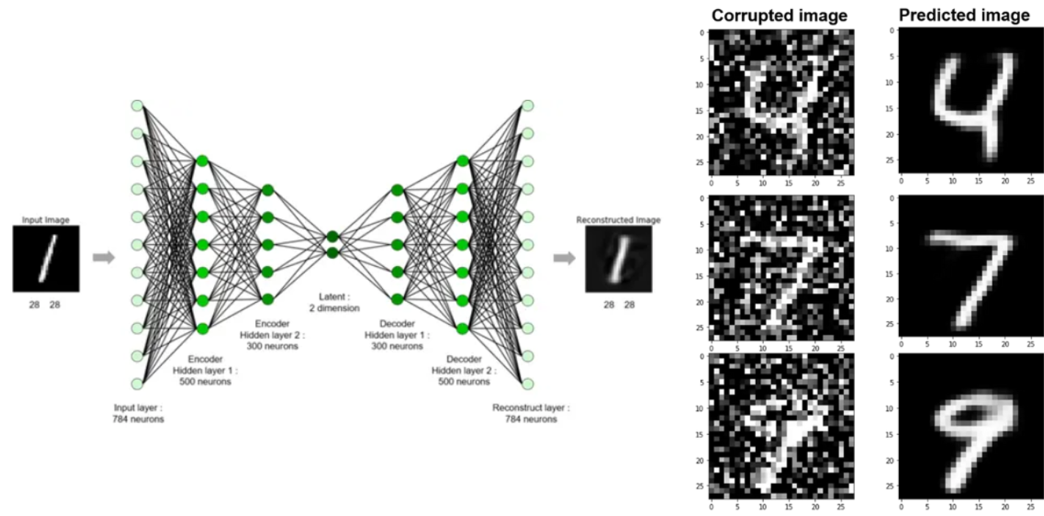

## Application dans notre cas

#### Descrpition du processus

Dans notre cas, un dataset de données "noisy" nous a été fourni et comme énoncé précédement, nous devons donc augmenter la qualité de l'image.

Pour se faire nous allons commencer par une étape importante, l'entrainement du modèle de l'auto-encodeur.

***Cette étape n'est a réaliser qu'une seule fois***. Elle permet de noiser manuellement des image d'un dataset prédéfini.

Pour notre cas, **nous avons sélectionné uniquement les photos** (étant donné que dans notre workflow notre mettrons notre auto-encodeur après la classification des images entre photo et non photo).

In [ ]:
# Importation des librairies
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import sys

# Permet d'autoreload les scripts exrérieurs (sans devoir relancer le kernel)
%load_ext autoreload
%autoreload 2

# Import du .env
import dotenv

# Chargement du .env !!!!!!!!!!!! CHANGER LE PATH !!!!!!!!!!!!!!
# Renvoie true si le .env est chargé
dotenv.load_dotenv('/tf/science-de-la-donnee/.env')

On va ensuite déclarer la majorité de nos variables comme les dossiers de destinations et de sources

In [23]:
# Changer les valeurs dans le .env des paths
source_folder = os.environ.get('SOURCE_NOISE_PATH')
destination_folder = os.environ.get('DESTINATION_NOISE_PATH')

# Dans le cas de la classification binaire on s'assure de bien sélectionner le sous-dossier "Photo" même s'il est possible d'étendre le bruitage des images
selected_subfolders = ["Photo"]#["Photo", "Category2"]  

# Facteur de bruit, plus cette valeur est élevée, plus le bruit va être présent
noise_factor = 50

On créer la fonction qui va bruiter nos images

In [19]:
# Création d'une fonction permetttant de créer du bruit sur les images
def add_noise(img):
    noise = np.random.normal(0, noise_factor, img.shape).astype(np.int16)  # Using int16 for the noise
    img = img.astype(np.int16)  # Convert the image to int16 format as well
    noised_img = img + noise  # Add noise
    noised_img = np.clip(noised_img, 0, 255)  # Clip to 0-255 range
    return noised_img.astype(np.uint8)  # Convert back to uint8

Puis on test la fonction sur une image donnée afin de s'assurer que l'image est bien bruitée

(193, 196, 177)
[212 254 190]


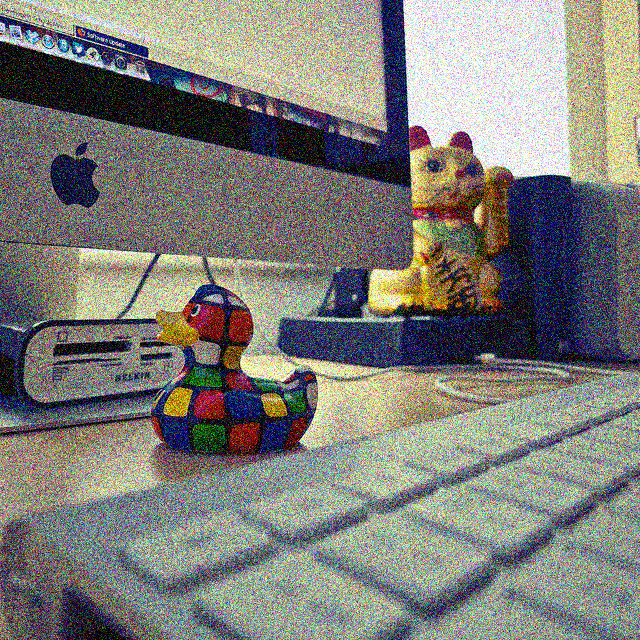

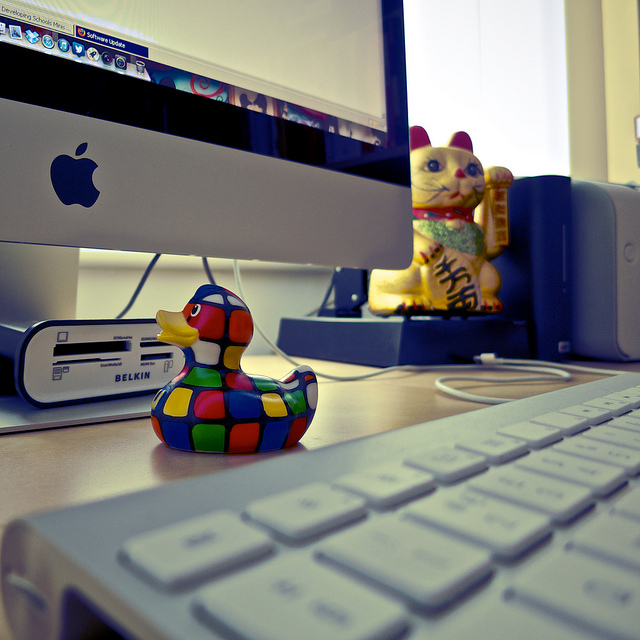

In [24]:
img= Image.open(source_folder+"Photo/photo_0005.jpg")
print(img.getpixel((0,0)))

# noise it the show the difference
noised_img = add_noise(np.array(img))

print(noised_img[0][0])


Image.fromarray(noised_img).show()
Image.fromarray(np.array(img)).show()

Voici un exemple d'image bruité à 25 de noise_factor :

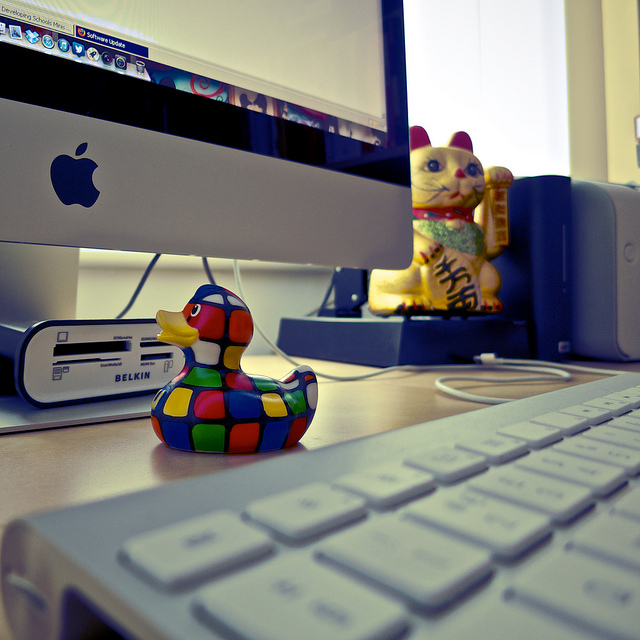
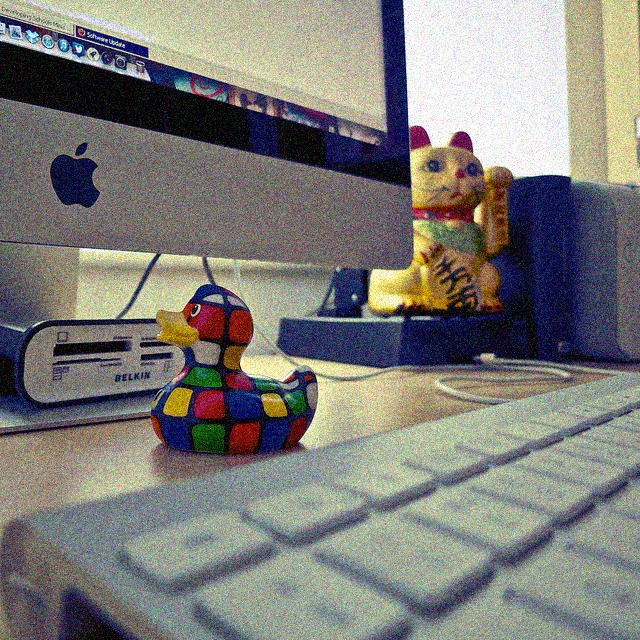

Et pour finir on généralise ça à **toutes** nos photos qui seront stockés dans un nouveau dossier

In [ ]:

os.makedirs(destination_folder, exist_ok=True)

total_files = 0
for subdir, _, files in os.walk(source_folder):
    total_files += len([f for f in files if f.endswith(".jpg")])

for category in selected_subfolders:
    category_path = os.path.join(source_folder, category)
    if os.path.isdir(category_path):
        dest_category_path = os.path.join(destination_folder, category)
        
        # Create destination subfolder if it doesn't exist
        os.makedirs(dest_category_path, exist_ok=True)
        
        # Count the number of images in this subfolder
        total_files = len([f for f in os.listdir(category_path) if f.endswith(".jpg")])
        
        with tqdm(total=total_files, desc=f"Processing {category}") as pbar:
            for filename in os.listdir(category_path):
                if filename.endswith(".jpg"):
                    img_path = os.path.join(category_path, filename)
                    
                    img = Image.open(img_path)
                    img_array = np.array(img)
                    
                    noised_img_array = add_noise(img_array)
                    
                    noised_img = Image.fromarray(noised_img_array)
                    noised_img.save(os.path.join(dest_category_path, filename))
                    
                    pbar.update(1)

#### Mise en application

#### Maintenance